In [1]:
# python
from tqdm.notebook import tqdm
import sys
import os
import importlib
# columnar analysis
import awkward as ak
import mplhep as hep
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import ffschema, sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline
import vector
import numpy as np
from scipy import stats
from scipy.stats import expon
from scipy.optimize import differential_evolution
import zfit

/opt/conda/lib/python3.9/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
2024-08-20 01:34:59.021388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 01:34:59.038399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 01:34:59.038419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
samples_off = [
    '4mu_500GeV_5GeV_0p08mm',
    '4mu_500GeV_5GeV_0p8mm',
    '4mu_500GeV_5GeV_8p0mm',
    '4mu_500GeV_5GeV_40p0mm',
    '4mu_500GeV_5GeV_80p0mm',
]

samples_pri = [
    '4mu_500GeV_5GeV_0p08mm',
    '4mu_500GeV_5GeV_0p8mm',
    '4mu_500GeV_5GeV_8p0mm',
    '4mu_500GeV_5GeV_40p0mm',
    '4mu_500GeV_5GeV_80p0mm',
]

In [3]:
fileset_off = utilities.make_fileset(samples_off, "ffntuple_official")
fileset_pri = utilities.make_fileset(samples_pri, "ffntuple_private")

events_off, events_pri = {}, {}

for i in tqdm(samples_off):
    fname = fileset_off[i][0]
    print(fname)
    events_off[i] = NanoEventsFactory.from_root(
        fname,
        treepath='ffNtuplizer/ffNtuple',
        schemaclass=ffschema.FFSchema,
    ).events()

    
for i in tqdm(samples_pri):
    fname = fileset_pri[i][0]
    print(fname)
    events_pri[i] = NanoEventsFactory.from_root(
        fname,
        treepath='ffNtuplizer/ffNtuple',
        schemaclass=ffschema.FFSchema,
    ).events()

  0%|          | 0/5 [00:00<?, ?it/s]

root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/official/SIDM_XXTo2ATo4Mu_mXX-500_mA-5_ctau-0p08_off.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/official/SIDM_XXTo2ATo4Mu_mXX-500_mA-5_ctau-0p80_off.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/official/SIDM_XXTo2ATo4Mu_mXX-500_mA-5_ctau-8p00_off.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/official/SIDM_XXTo2ATo4Mu_mXX-500_mA-5_ctau-40p0_off.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/official/SIDM_XXTo2ATo4Mu_mXX-500_mA-5_ctau-80p0_off.root


  0%|          | 0/5 [00:00<?, ?it/s]

root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/Private/ffNtuple_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_v6.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/Private/ffNtuple_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p8_v6.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/Private/ffNtuple_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-8p0_v6.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/Private/ffNtuple_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-40p0_v6.root
root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/ffNuple/Private/ffNtuple_SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-80p0_v6.root


In [4]:
print(events_off["4mu_500GeV_5GeV_0p08mm"].fields)

['run', 'event', 'lumi', 'fixedGridRho', 'puInteractionNum', 'trueInteractionNum', 'weight', 'weightProduct', 'HLT_DoubleL2Mu23NoVtx_2Cha', 'HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched', 'HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed', 'HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched', 'HLT_DoubleL2Mu25NoVtx_2Cha', 'HLT_DoubleL2Mu25NoVtx_2Cha_NoL2Matched', 'HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed', 'HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_NoL2Matched', 'HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4', 'HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4', 'HLT_Mu38NoFiltersNoVtxDisplaced_Photon38_CaloIdL', 'HLT_Mu43NoFiltersNoVtx_Photon43_CaloIdL', 'tomatchfilter_result', 'tomatchfilter_HLTDoubleL2Mu23NoVtx2Cha', 'tomatchfilter_HLTDoubleL2Mu23NoVtx2ChaNoL2Matched', 'tomatchfilter_HLTDoubleL2Mu23NoVtx2ChaCosmicSeed', 'tomatchfilter_HLTDoubleL2Mu23NoVtx2ChaCosmicSeedNoL2Matched', 'tomatchfilter_HLTDoubleL2Mu25NoVtx2ChaEta2p4', 'tomatchfilter_HLTDoubleL2Mu25NoVtx2ChaCosmicSeedEta2p4', 'L1TOHLT_DoubleL2Mu25NoVtx_2Cha_Cosmic

In [5]:
print(events_off["4mu_500GeV_5GeV_0p08mm"].gen.fields)

['x', 'y', 'z', 't', 'charge', 'pid', 'daupid', 'daudr', 'posx', 'posy', 'posz', 'dauposdr', 'dauposdz', 'dauposdphi', 'dauvtx', 'vtx']


In [6]:
print(events_off["4mu_500GeV_5GeV_0p08mm"].gen.vtx.fields)

['x', 'y', 'z']


In [7]:
print(events_off["4mu_500GeV_5GeV_0p08mm"].gen.dauvtx.fields)

['x', 'y', 'z']


In [8]:
print(events_off["4mu_500GeV_5GeV_0p08mm"].gen.vtx)
print(events_off["4mu_500GeV_5GeV_0p08mm"].gen.dauvtx)

[[{x: 0.0101, y: 0.0419, z: 3.31}, {x: 0.0101, ... {x: 0.173, y: 0.0361, z: -3.06}]]
[[{x: 0.0101, y: 0.0419, z: 3.31}, {x: 0.0415, ... {x: nan, y: nan, z: nan}]]


In [42]:
events_off["4mu_500GeV_5GeV_0p08mm"].gen.vtx

<ThreeVectorArray [[{x: 0.0101, y: 0.0419, ... z: -3.06}]] type='52500 * var * T...'>

In [9]:
print(events_off["4mu_500GeV_5GeV_0p08mm"].gen.dauvtx - events_off["4mu_500GeV_5GeV_0p08mm"].gen.vtx)

[[{x: 0, y: 0, z: 0}, {x: 0.0314, y: 0.000421, ... {x: nan, y: nan, z: nan}]]


In [10]:
print((events_off["4mu_500GeV_5GeV_0p08mm"].gen.dauvtx - events_off["4mu_500GeV_5GeV_0p08mm"].gen.vtx).rho)

[[0, 0.0439, 0.00249, nan, nan, nan, nan], ... [0, 1.3, 0.192, nan, nan, nan, nan]]


In [ ]:
print((events_off["4mu_500GeV_5GeV_0p08mm"].gen.dauvtx - events_off["4mu_500GeV_5GeV_0p08mm"].gen.vtx).p)

[[0, 0.0439, 0.00249, nan, nan, nan, nan], ... [0, 1.3, 0.192, nan, nan, nan, nan]]


In [4]:
def extract_values(events, sample):
    
    masked_gen = events["{0}".format(sample)].gen[(abs(events["{0}".format(sample)].gen.pid) == 32) & (abs(events["{0}".format(sample)].gen.daupid) == 13)]
    
    masked_gen_vec = vector.zip({
        "px": masked_gen.x,
        "py": masked_gen.y,
        "pz": masked_gen.z,
        "e": masked_gen.t})
    
    masked_gen_vec_x = masked_gen_vec.x
    masked_gen_vec_y = masked_gen_vec.y
    masked_gen_vec_z = masked_gen_vec.z
    masked_gen_vec_t = masked_gen_vec.t
    
    rho = ak.flatten((masked_gen.dauvtx - masked_gen.vtx).rho)
    gamma = ak.flatten(masked_gen_vec.gamma)
    beta = ak.flatten(masked_gen_vec.beta)
    
    return rho, gamma, beta

In [10]:
def plotting(events, sample, types, ranges, i, j, co):
    
    plt_range = (0, ranges)
    
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = rho/(gamma * beta)
    P = stats.expon.fit(lxyz_gb)
    
    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample+"_"+types, density=True, color=co)
    ax[i][j].plot(np.linspace(*plt_range,100), stats.expon.pdf(np.linspace(*plt_range,100), *P), label=fr"exp[ -(x - {P[0]:.3e}) / {P[1]:.3e} ] / {P[1]:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

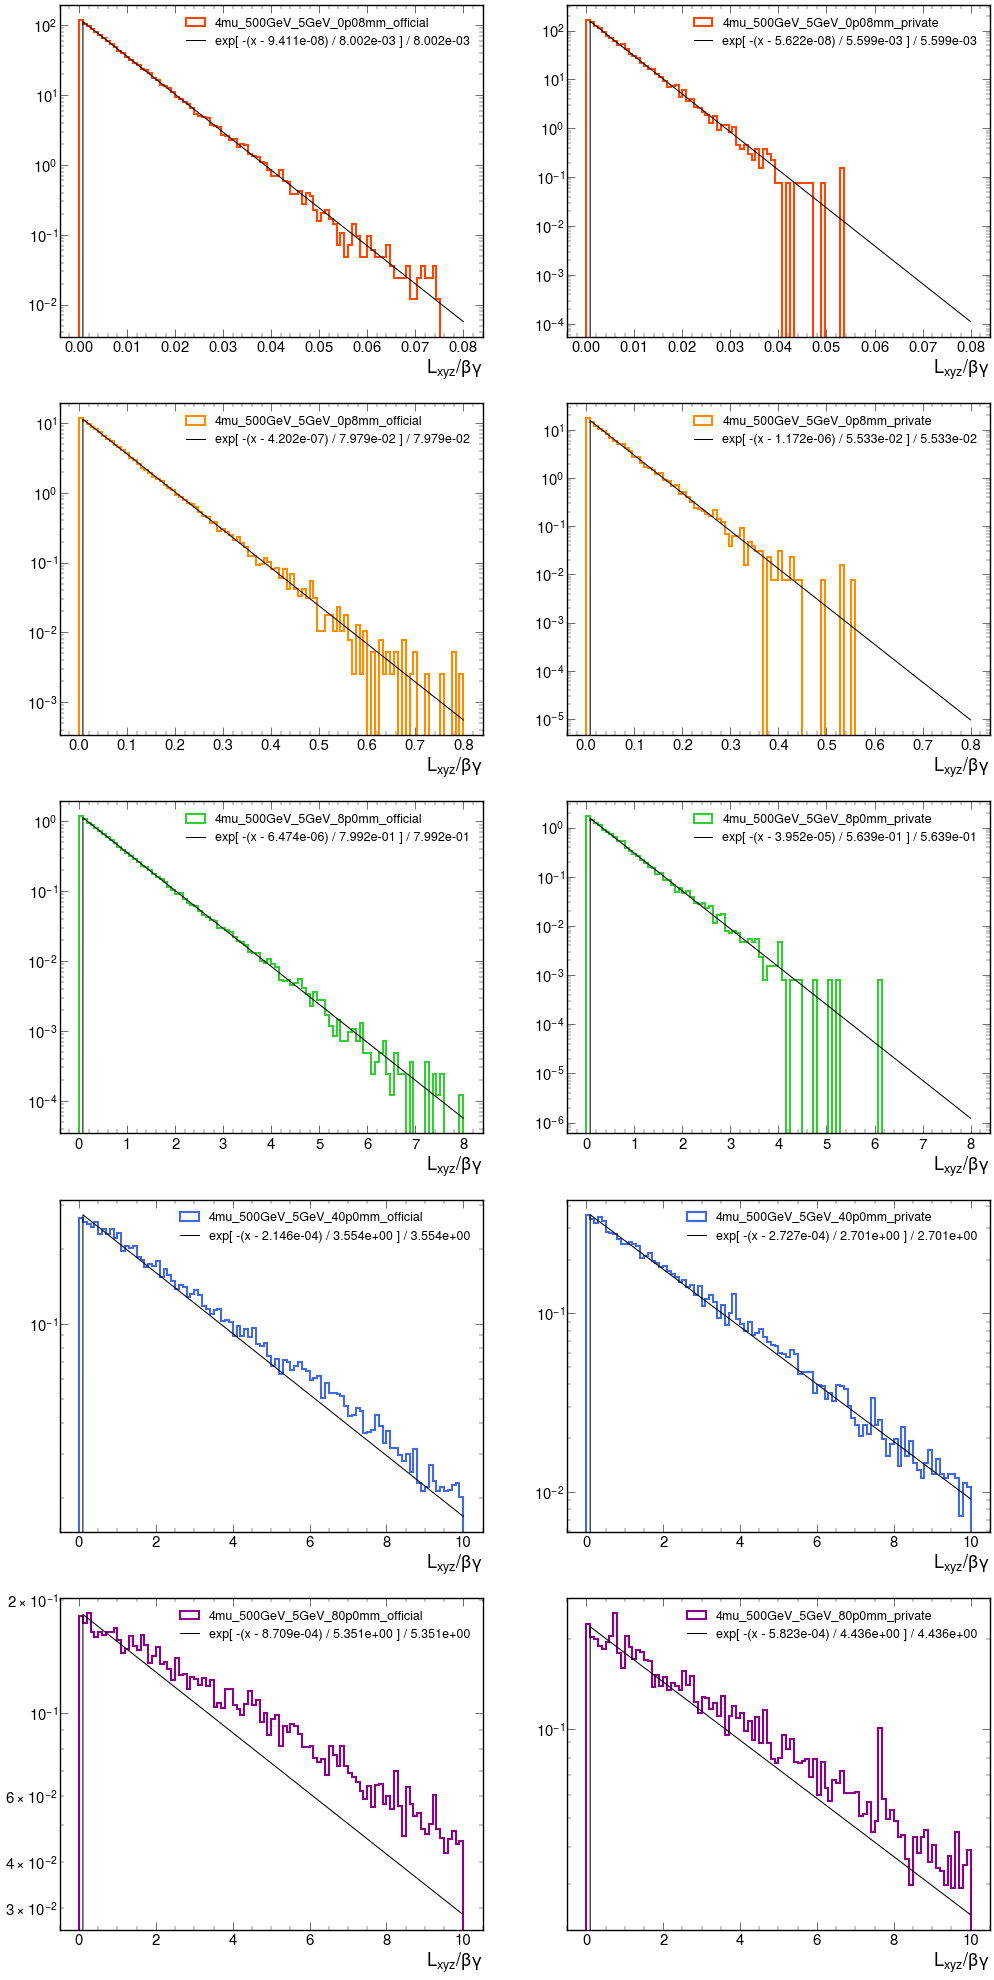

In [11]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24, 50)) 

plotting(events_off, "4mu_500GeV_5GeV_0p08mm", "official", 0.08,0,0, "orangered")
plotting(events_pri, "4mu_500GeV_5GeV_0p08mm", "private", 0.08,0,1, "orangered")

plotting(events_off, "4mu_500GeV_5GeV_0p8mm", "official", 0.8,1,0, "darkorange")
plotting(events_pri, "4mu_500GeV_5GeV_0p8mm", "private", 0.8,1,1, "darkorange")

plotting(events_off, "4mu_500GeV_5GeV_8p0mm", "official", 8,2,0, "limegreen")
plotting(events_pri, "4mu_500GeV_5GeV_8p0mm", "private", 8,2,1, "limegreen")

plotting(events_off, "4mu_500GeV_5GeV_40p0mm", "official", 10,3,0, "royalblue")
plotting(events_pri, "4mu_500GeV_5GeV_40p0mm", "private", 10,3,1, "royalblue")

plotting(events_off, "4mu_500GeV_5GeV_80p0mm", "official", 10,4,0, "darkmagenta")
plotting(events_pri, "4mu_500GeV_5GeV_80p0mm", "private", 10,4,1, "darkmagenta")

In [13]:
def zfit_plotting(events, sample, types, ranges, i, j, co):
    
    plt_range = (0, ranges)
    rho, gamma, beta = extract_values(events, sample)
    
    lxyz_gb = ak.to_numpy(rho/(gamma * beta))
    obs_space = zfit.Space("lxyz_gb", limits=plt_range)
    data = zfit.Data.from_numpy(obs=obs_space, array=lxyz_gb)
    
    lambda_param = zfit.Parameter("lambda", 1)
    exp_model = zfit.pdf.Exponential(lambda_param, obs=obs_space)

    nll = zfit.loss.UnbinnedNLL(model=exp_model, data=data)

    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)
    param_val = result.params[lambda_param]['value']
    
    offset = 0
    scale_param = 1 / param_val

    ax[i][j].hist(lxyz_gb, range=plt_range, linewidth=3, bins=100, histtype='step', label=sample+"_"+types, density=True, color=co)

    x_vals = np.linspace(*plt_range, 100)
    pdf_vals = exp_model.pdf(x_vals, norm_range=obs_space)
    ax[i][j].plot(x_vals, pdf_vals, label=fr"exp[ -(x - {offset:.3e}) / {scale_param:.3e} ] / {scale_param:.3e}", color='black')
    ax[i][j].set_yscale("log")
    ax[i][j].legend(fontsize=18)
    ax[i][j].set_xlabel(r"$L_{xyz}$/$\beta\gamma$")

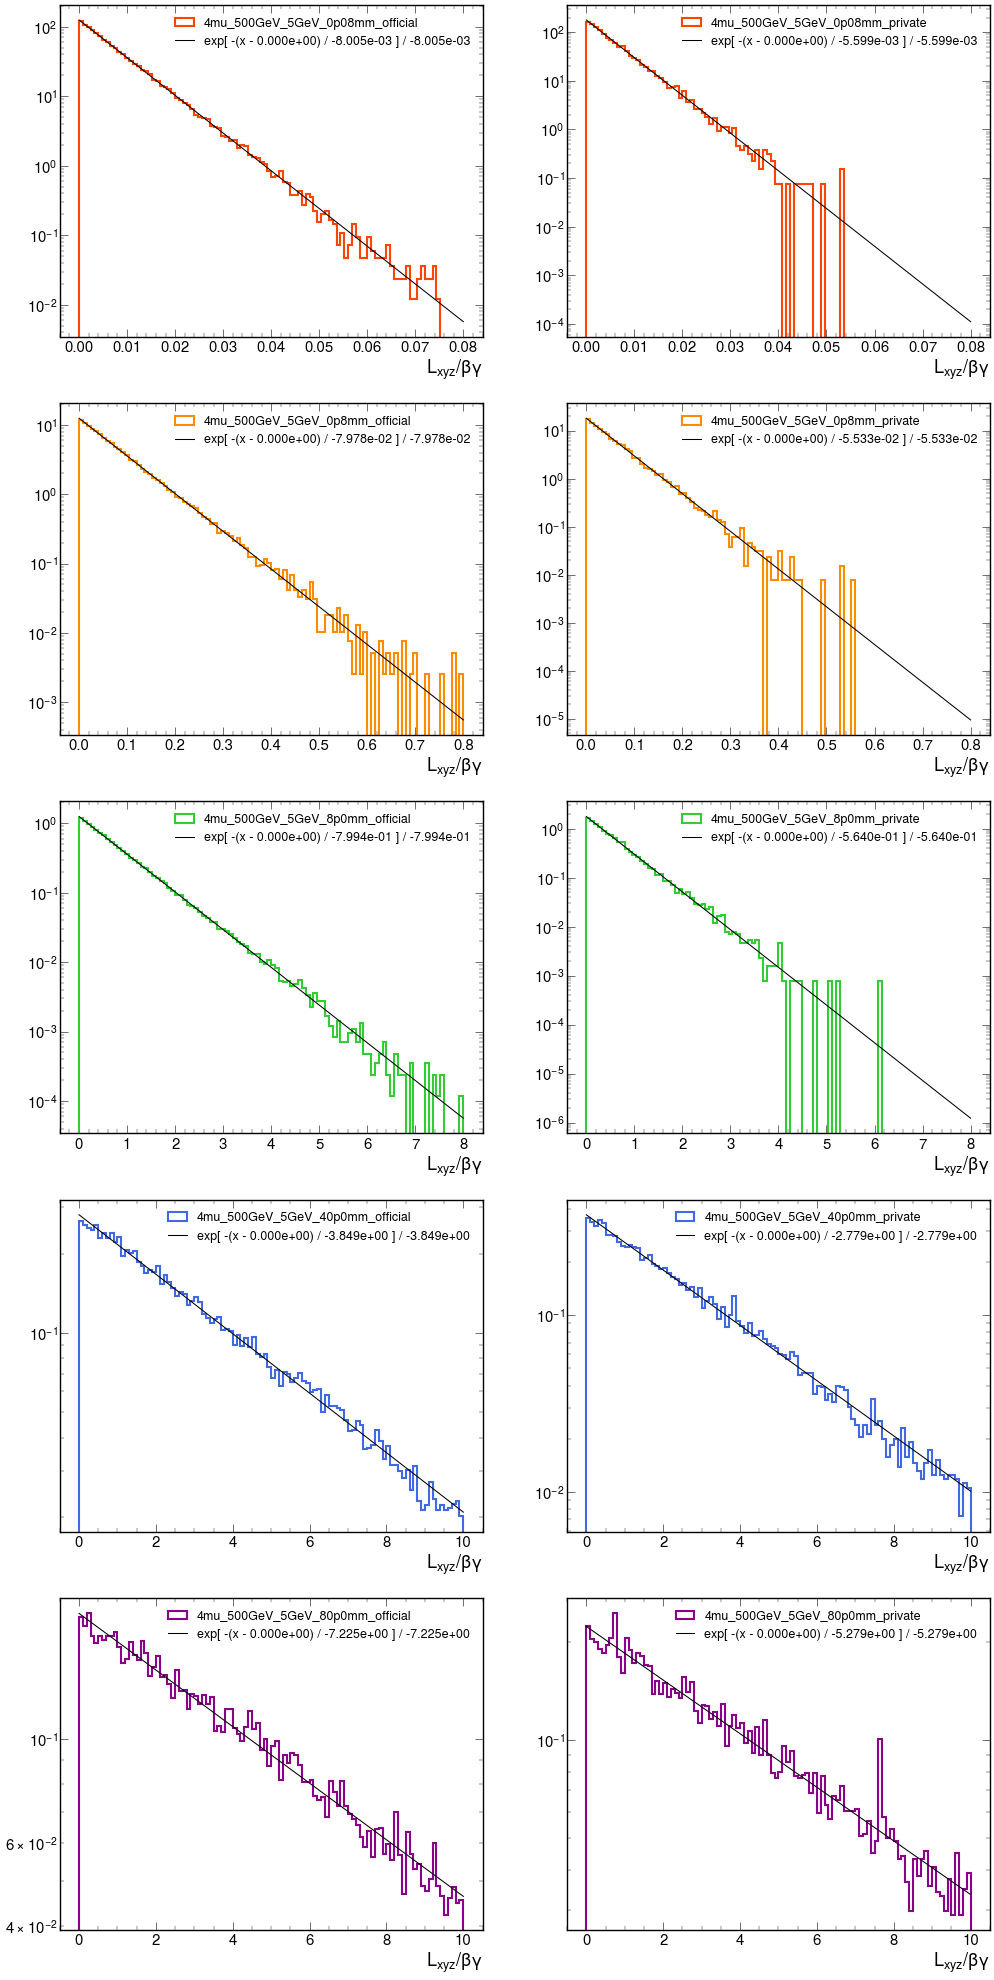

In [14]:
plt.style.use(hep.style.CMS)
fig, ax = plt.subplots(5, 2, figsize=(24, 50)) 

zfit_plotting(events_off, "4mu_500GeV_5GeV_0p08mm", "official", 0.08,0,0, "orangered")
zfit_plotting(events_pri, "4mu_500GeV_5GeV_0p08mm", "private", 0.08,0,1, "orangered")

zfit_plotting(events_off, "4mu_500GeV_5GeV_0p8mm", "official", 0.8,1,0, "darkorange")
zfit_plotting(events_pri, "4mu_500GeV_5GeV_0p8mm", "private", 0.8,1,1, "darkorange")

zfit_plotting(events_off, "4mu_500GeV_5GeV_8p0mm", "official", 8,2,0, "limegreen")
zfit_plotting(events_pri, "4mu_500GeV_5GeV_8p0mm", "private", 8,2,1, "limegreen")

zfit_plotting(events_off, "4mu_500GeV_5GeV_40p0mm", "official", 10,3,0, "royalblue")
zfit_plotting(events_pri, "4mu_500GeV_5GeV_40p0mm", "private", 10,3,1, "royalblue")

zfit_plotting(events_off, "4mu_500GeV_5GeV_80p0mm", "official", 10,4,0, "darkmagenta")
zfit_plotting(events_pri, "4mu_500GeV_5GeV_80p0mm", "private", 10,4,1, "darkmagenta")